In [1]:
# required for colab only
from google.colab import files
uploaded = files.upload()

Saving wind_SUD.csv to wind_SUD.csv


# Exploratory analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from scipy.signal import periodogram

In [4]:
zone = 'SUD'
PATH = f'wind_{zone}.csv'
data = pd.read_csv(PATH)

In [5]:
# convert date to format datetime
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

<ipython-input-5-be3e7cecb851>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


In [6]:
# complete all the datetimes
all_datetimes = pd.DataFrame(pd.date_range(datetime(df.date.min().year, 1, 1), df.date.max(), freq='d'), columns=["date"])
df = all_datetimes.merge(df, on=['date'], how='outer')
df.set_index('date', inplace=True)

In [7]:
# fill the missing values with the closest available data
df.energy = df.energy.fillna(method='ffill').fillna(method='bfill')

In [8]:
# check if every year has 365 data points (except the last year)
df = df.reset_index(drop=False)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.set_index('date', inplace=True)

count_year_df = df.groupby('year')['energy'].count()

In [9]:
# use only complete years
condition = count_year_df >= 365
complete_years = count_year_df.loc[condition].index
df = df.loc[df.year.isin(complete_years)]
df

,energy,year
date,,
2015-01-01,61.5,2015
2015-01-02,61.5,2015
2015-01-03,20.8,2015
2015-01-04,44.8,2015
2015-01-05,40.3,2015
...,...,...
2021-12-27,15.6,2021
2021-12-28,24.3,2021
2021-12-29,3.6,2021


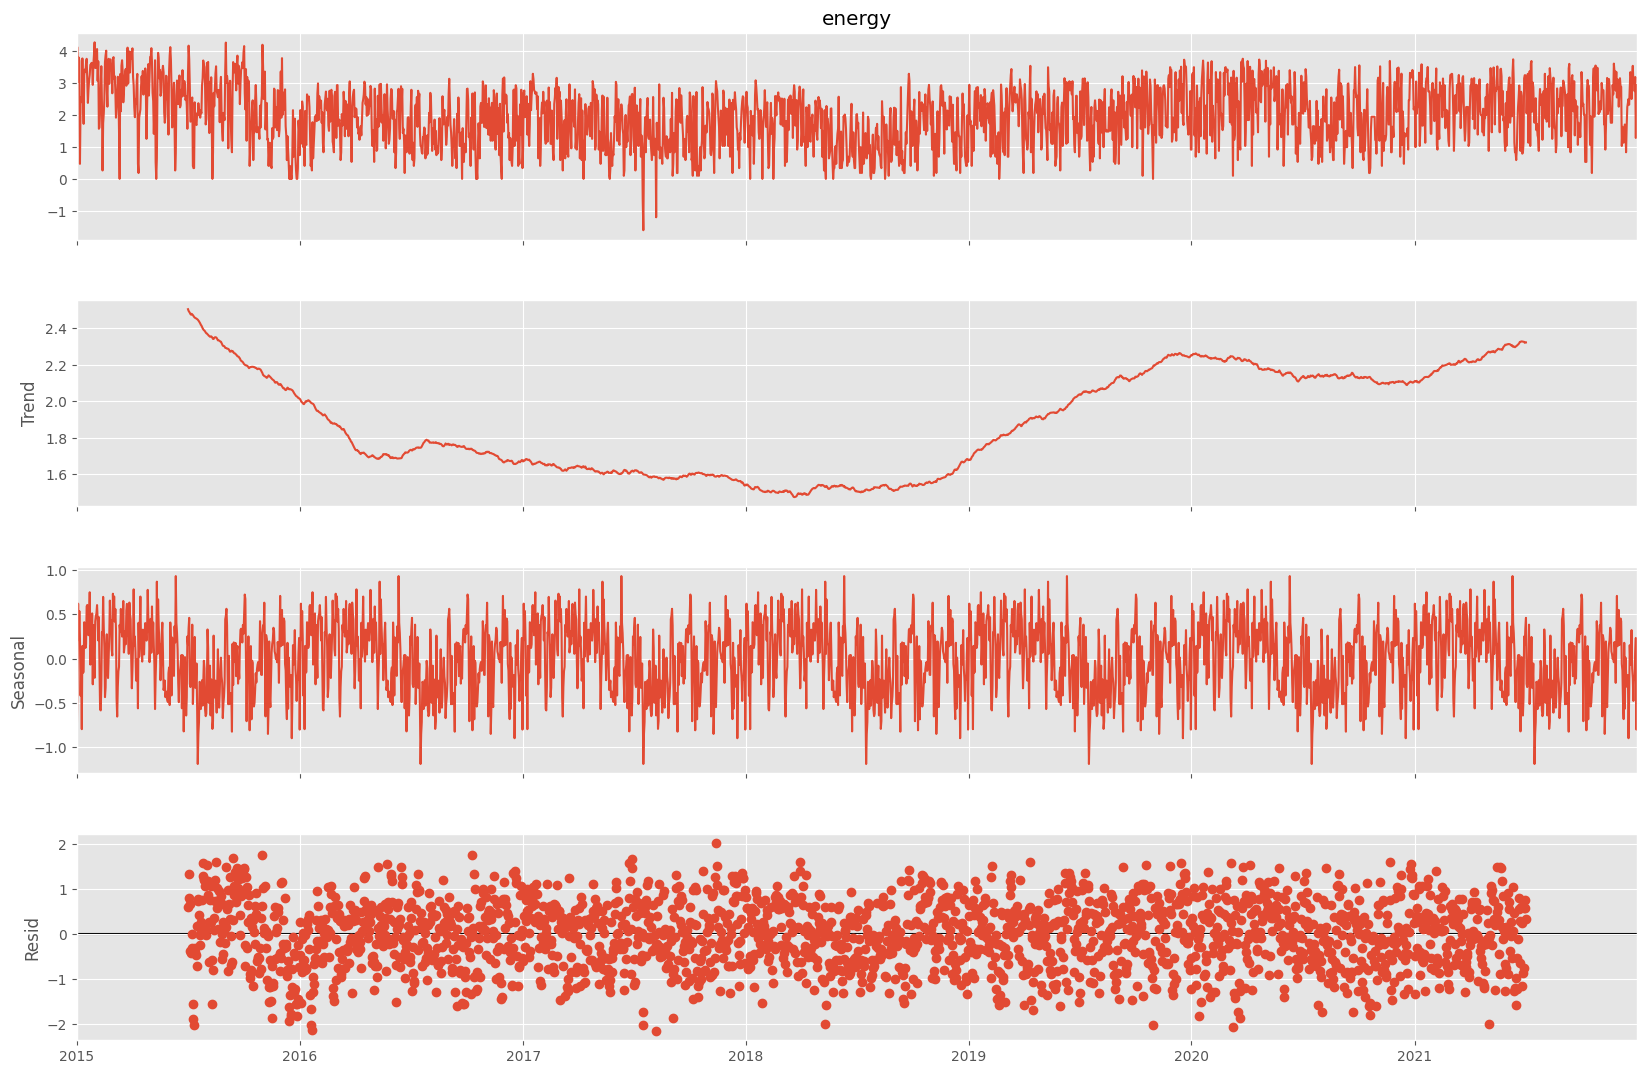

In [10]:
dflog = np.log(df.loc[df.year < 2022, 'energy'])

res = seasonal_decompose(dflog, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

In [ ]:
res.trend.dropna()

date
2015-07-02    2.506049
2015-07-03    2.496796
2015-07-04    2.491407
2015-07-05    2.486102
2015-07-06    2.479413
                ...   
2021-06-28    2.327141
2021-06-29    2.326536
2021-06-30    2.321205
2021-07-01    2.323285
2021-07-02    2.323399
Name: trend, Length: 2193, dtype: float64

In [21]:
# fit an ARIMA model and plot residual errors
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
# fit model
x = res.trend
dates0 = df.loc[df.year <= 2022].index
x.index=dates0
x = x.dropna()
# model = ARIMA(x, order=(2,1,0))
# model_fit = model.fit()

# fit auto_arima
!pip install pmdarima
from pmdarima.arima import auto_arima

model = auto_arima(y=x, start_p=2, start_d=1, max_d=3, start_q=0, max_q=0, seasonal=False)
model_fit = model.fit(y=x)

In [19]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# density plot of residuals
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
# print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2193
Model:               SARIMAX(5, 2, 0)   Log Likelihood                9567.518
Date:                Wed, 29 Nov 2023   AIC                         -19123.036
Time:                        21:40:45   BIC                         -19088.883
Sample:                    07-02-2015   HQIC                        -19110.553
                         - 07-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5134      0.020    -25.070      0.000      -0.554      -0.473
ar.L2         -0.4228      0.023    -18.106      0.000      -0.469      -0.377
ar.L3         -0.3124      0.024    -13.260      0.0

ValueError: ignored

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Test RMSE: 0.007


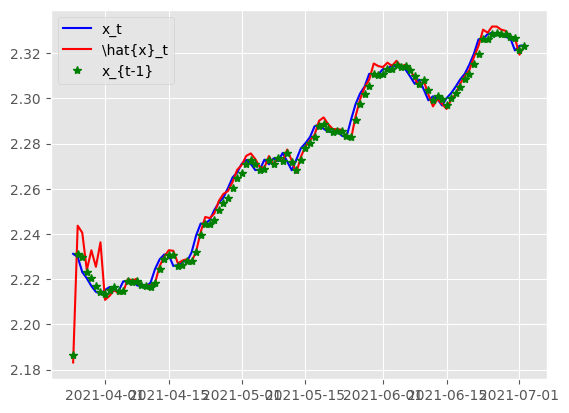

In [22]:
# split into train and test sets
test_steps = 100
# train = x[:test_steps]
# test = x[test_steps:]
train, test = x[:test_steps], x[-test_steps:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 # model = SARIMAX(history, trend='c', order=(5,1,0), enforce_stationarity=False, enforce_invertibility=False)
 model = ARIMA(history, order=(5,2,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(np.mean(np.square(test - predictions)))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
# plt.plot(x, color='k', label='x_t')
plt.plot(test, color='b', label='x_t')
plt.plot(test.index, predictions, color='red', label='\hat{x}_t')
plt.plot(test.index, np.concatenate(([train[-1]], test[:-1].T), axis=None), 'g*', label="x_{t-1}")
plt.legend()
plt.show()

**H-estimation**
The Hurst exponent (H) is referred to as the "index of dependence" or "index of long-range dependence". It quantifies the relative tendency of a time series either to regress strongly to the mean or to cluster in a direction.
A value of $H \in (0.5,1)$ defines a time series with long-term positive autocorrelation, that is to say that autocorrelation decays slower than exponential, following a power law. A value of $ H\in(0,0.5)$ indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high, with this tendency to switch between high and low values lasting a long time into the future, also following a power law. Finally, if  $H=0.5$ denotes short-memory, with (absolute) autocorrelations decaying exponentially quickly to zero.
H will be estimated using the R/S algorithm, which is based on the asymptotic behaviour of the rescaled range as a function of $n$ observations (time span):
\begin{equation}
 E\left[\frac{R(n)}{S(n)}\right] = Cn^H\; \text{ as }\; n →∞\;,
\end{equation}
where:
\begin{enumerate}
  \item $R(n)$ is the range of the first $n$ cumulative deviations from the mean;
  \item $S(n)$ is the series (sum) of the first $n$ standard deviations;
  \item $C$ is a positive constant.
\end{enumerate}
A crucial role in the calibration routine is played by $n$.
Therefore. we perform a pretuning calibration, in order to obtain the optimal minimal window and maximal window size for R/S algorithm calibration.


**ARIMA**
The trend will be predicted by using an ARIMA model. First of all, we perform an autoARIMA pretuning calibration over the train set of observations, which allows us to choose the optimal tuple $(p^*,d^*,q^*)$ to define our ARIMA model.
Then we perform the forecast 1-step ahead in the test set computing the rmse and comparing the forecast with the test set.